In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import interpolate
import scipy
from scipy import stats
import glob
import colour
from colour.plotting import *

# create a tungsten incandescent object at 1700 K
tungsten_values = {
    "wavelength_list": [400e-9, 700e-9, 200],
    "Material_List": ["Air",  "W", "Air"],
    "Thickness_List": [0, 900e-9, 0],
    "temperature": 1700,
    "therml": True
}


sf = wptherml.SpectrumFactory()
w = sf.spectrum_factory('Tmm', tungsten_values)


 Your spectra have been computed! 😎 
 Your therml spectra have been computed! 🔥 


Read in the emission spectra data from the Meth_and_Propoxy_TTz folder!

In [2]:
file_location = os.path.join('Meth_and_Butoxy_TTz_sub','*.txt')
filenames = glob.glob(file_location)
print(filenames)

['Meth_and_Butoxy_TTz_sub/4.3.txt', 'Meth_and_Butoxy_TTz_sub/3.1.txt', 'Meth_and_Butoxy_TTz_sub/1.3.txt', 'Meth_and_Butoxy_TTz_sub/3.3.txt', 'Meth_and_Butoxy_TTz_sub/11.3.txt']


Now read in the emission spectra from each file, compute the CIE and RGB values for each spectrum, print
the filename and CIE values, and store the RGB values to a list.  We will use that RGB list subsequently to plot the values on the CIE color gamut.

In [3]:
cie_x = []
cie_y = []
rgb_list = []
for file in filenames:
    data = np.loadtxt(file)
    emission_spline = interpolate.interp1d(data[:,0], data[:,1])
    # make sure this spline is good!
    assert np.allclose(emission_spline(data[:,0]), data[:,1], 1e-4)
    emission_prediction = emission_spline(w.wavelength_array * 1e9)   
    cie = w.compute_cie(emission_prediction)
    cie_x.append(cie[0])
    cie_y.append(cie[1])
    rgb = w.compute_rgb(emission_prediction)
    rgb_list.append(rgb)
    print(F"{file[20:]}, {cie[0]}, {cie[1]}, {cie[2]}")
    


sub/4.3.txt, 0.21462838170558254, 0.24162551834020488, 0.5437460999542126
sub/3.1.txt, 0.29638444631058547, 0.3397604746235261, 0.36385507906588843
sub/1.3.txt, 0.38765294793108723, 0.4358806035232374, 0.17646644854567542
sub/3.3.txt, 0.25580985943927104, 0.2850116477785543, 0.4591784927821746
sub/11.3.txt, 0.159450452090115, 0.16590045531755984, 0.6746490925923252


In [4]:
# turn the cie values into numpy arrays
np_cie_x = np.array(cie_x)
np_cie_y = np.array(cie_y)

sorted_indices = np.argsort(np_cie_x)
print(sorted_indices)

sorted_cie_x = np_cie_x[sorted_indices]
sorted_cie_y = np_cie_y[sorted_indices]

[4 0 3 1 2]


Notes to Lane: 
1. I found some syntax that allows plotting multiple layers on the CIE diagram, which allows us to plot the CIE values directly (i.e. no more mapping them to RGB values), and will also allow us to plot a line of best fit.

2. Right now, I am plotting both a scatter plot and a line through all the points (rather than a line of best fit) with the following code:

`plt.scatter(cie_x, cie_y)
plt.plot(cie_x, cie_y, 'black')`

You can find a line of best fit using the scipy.stats function `linregress` as follows:

`slope, intercept, r, p, se = scipy.stats.linregress(cie_x, cie_y)`

and then define a line of best fit along the actual CIE x values simply as 

`y_fit = slope * cie_x`

You can then change the one `plt.plot()` command to 
`plt.plot(cie_x, cie_y, 'black')`
and hopefully that will plot the line of best fit on top of the actual CIE values.



In [5]:
# ==> Add line to compute slope, etc, using scipy.stats.linregress here! <==
slope, intercept, r, p, se = scipy.stats.linregress(cie_x, cie_y)
y_fit = slope * np.array(cie_x)+intercept
print(slope)
print(r)
print(y_fit)
print(intercept)

1.17835989362
0.998492954048
[ 0.23688966  0.33322772  0.44077487  0.28541626  0.1718702 ]
-0.0160198210163


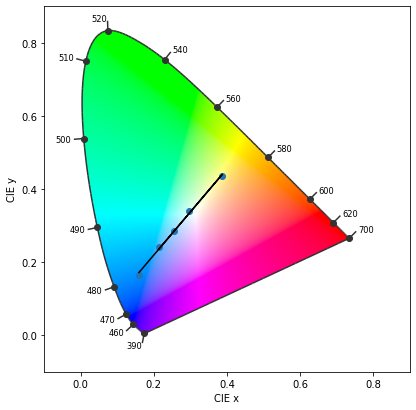

In [7]:
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)
plt.scatter(cie_x, cie_y)
# ==> Change the plt.plot() line below so that it is plotting the y-vales associated
# ==> with the slope * cie_x where slope comes from scipy.stats.linregress
plt.plot(cie_x, y_fit, 'black') 
plt.title("")
plt.xlim(-0.1, 0.9)
plt.ylim(-0.1, 0.9)
plt.savefig('updated_meth_and_butoxy_TTz_hr.png', dpi = 300)
#colour.plotting.render(
 #   standalone=True,
 #   bounding_box = (-0.1, 0.9, -0.1, 0.9)
#)
